In [1]:
#numpy
import numpy

# multidimensional arrays
import numpy as np

# random choice
import random

# inline plots
import matplotlib.pyplot as plt
%matplotlib inline

# nicer figures
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Return to the origin


For a *finite* random walk of (large) length $n$, it is known that the expected number of returns to the origin $T_n$ scales like follows:
$$
\left\langle T_n \right\rangle \sim \left\{
\begin{array}{ll}
\sqrt{n} & d=1 \\
\log(n) & d=2 \\
C_d & d\geq 3
\end{array}
\right.
$$


<img src="images/3.1.png" width="600">

Notice that for $d \geq 3$, $\left\langle T_n \right\rangle$ does **not** grow with $n$, which must mean that the walker somehow "escapes" and never returns back to the origin. The probability of return to the origin is less than 1! For an infinite-length random walk, indeed the probability of returning to the origin $\rho$ is seen to be

$$
\rho \sim \left\{
\begin{array}{ll}
1 & d=1 \\
1 & d=2 \\
<1 & d\geq 3
\end{array}
\right.
$$

The *intuitive* explanation of this amazing fact is that, as the dimension $d$ grows, there are "more directions available", and so more chances for the walker to "get lost" and never return to the origin. There is of course a formal proof as well, but today we will do a **computational verification** of these facts, which is no substitute for a formal proof but is often all we can do!

## Generating Random Walks


### Exercise 3.1
Write a function that generates a random walk of given length in $d$ dimensions. Your random walker should move as follows:

+ At each time-step, the walker moves only in one direction.
+ At each time-step, the walker moves only by -1 or +1

Your function should return a numpy array of shape (`length`, `dim`). Example:
```python
>>> # create a RW of length 10 in dimension 3
>>> traj = get_traj(length=10, dim=3)
>>> # check that the output has the right shape
>>> traj.shape
(10, 3)
```

In [2]:
def get_traj(length=100, dim=2):
    """Generate a RW in d dimensions
    
    Parameters
    ----------
    length: int
        Length of the RW.
    dim: int
        Dimension of the RW

    Returns
    -------
    traj : np.ndarray, (length, dim)
        The positions of the RW.
    
    Notes
    -----
    At each time-step, the walker moves in only one direction.
    At each time-step, the walker moves by -1 or +1
    """
    traj = np.ndarray(shape=(length, dim), dtype = int)
    seq = [1,-1]
    
    traj[0,:] = 0 #per posizionarmi nell'orgine
    
    for i in range (1,length):
        n = random.randint(0,dim-1)
        traj[i,:] = traj [i-1,:]
        traj[i,n] += random.choice(seq)

    return traj

### Verification
To make sure that your function works correctly, execute the following cell. Notice the use of `assert` statements: execution should fail if something goes wrong. If everything is fine, nothing should happen.

In [3]:
# basic checks for your RW generator
for dim in range(1, 5):
    for length in [10, 100, 200, 500]:
        traj = get_traj(length=length, dim=dim)
        # make sure traj has the right shape
        assert traj.shape == (length, dim)
        # make sure all steps are -1 or 1 in only one direction
        assert np.all(np.sum(np.diff(traj, axis=0) != 0, axis=1) == np.ones(length - 1))

### Exercise 3.2
Plot a random walk of length $10^4$ for $d=1$ (time in x-axis, position in y-axis) and $d=2$ (x,y components in x,y-axis). Remember to use **axis labels**.

In [4]:
%%time
# it is better if you use one cell to generate the random walks, and a second cell to plot them
RW_1d = get_traj(10**4,1)
RW_2d = get_traj(10**4,2)

CPU times: user 41.4 ms, sys: 4.09 ms, total: 45.5 ms
Wall time: 43.3 ms


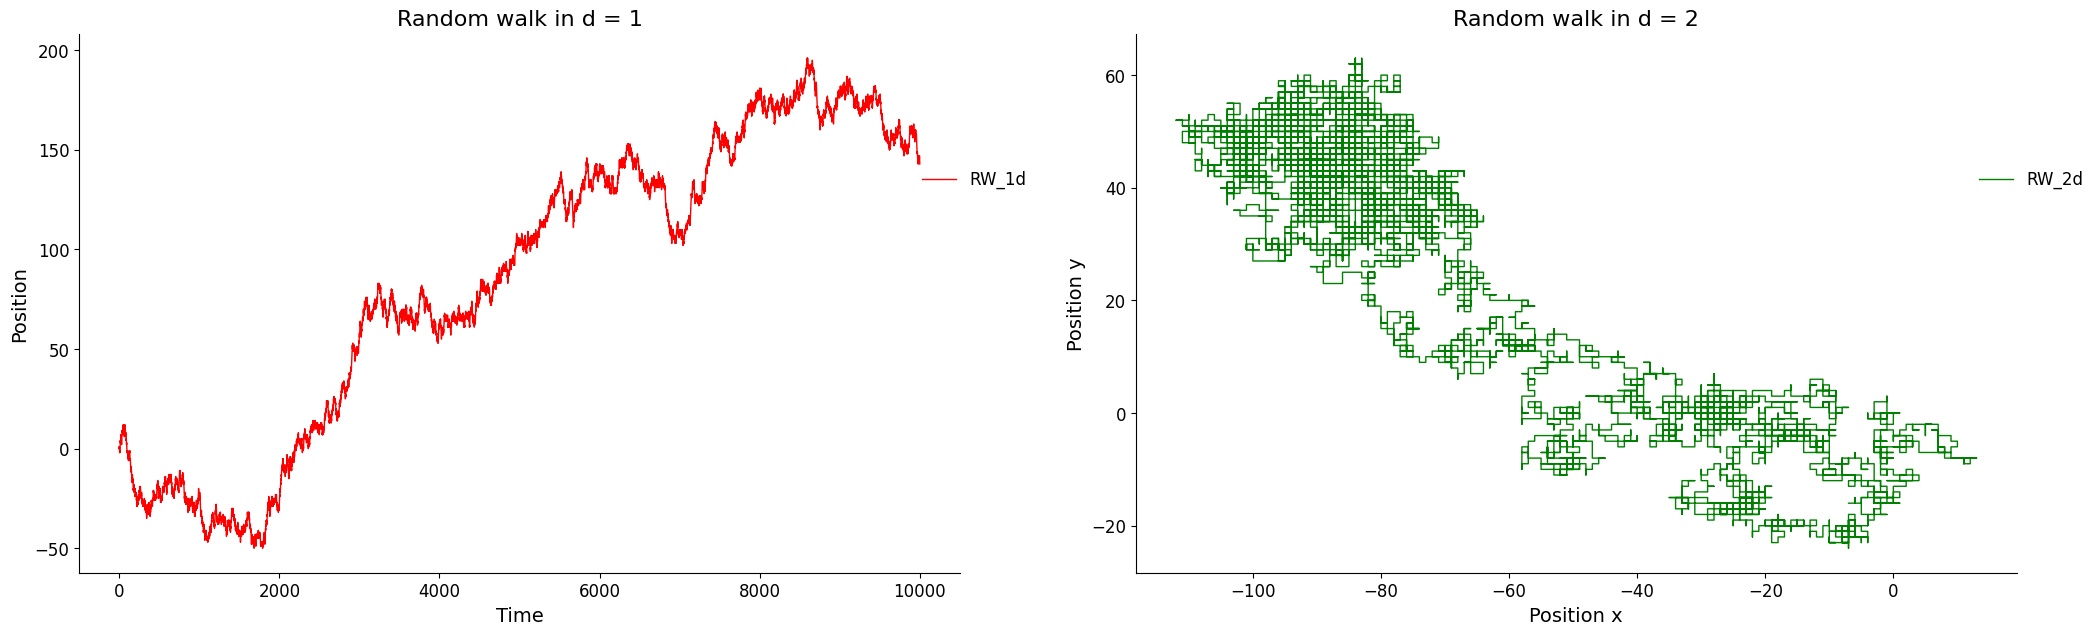

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))

# plot d=1
ax1.plot(
    RW_1d,
    color="red",
    lw=1,
    label="RW_1d"
);

#plot d=2
ax2.plot(
    RW_2d[:,0], RW_2d[:,1],
    color="green",
    lw=1,
    label="RW_2d"
);

# add labels for axes
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")

ax2.set_xlabel("Position x")
ax2.set_ylabel("Position y")

# add legend
ax1.legend(loc=(0.95, 0.7), frameon=False)
ax2.legend(loc=(0.95, 0.7), frameon=False)

# add title
ax1.set_title("Random walk in d = 1");
ax2.set_title("Random walk in d = 2");

## Counting the number of returns to the origin
Since we are interested in how **the expected number of returns to the origin** scales with the RW length, we don't need to store the whole trajectory of each simulation (we will be performing many simulations!). 

### Exercise 3.3
Write a function that generates a RW of given length and dimension (calling `get_traj`), and returns the number of times it returned to the origin. To count the number of returns to the origin, you might need to use the following functions:
```python
np.all()
np.zeros()
```

In [6]:
def get_num_returns(length, dim):
    
    traj = get_traj(length, dim)
    
    # count how many times it goes through the origin
    zeros = np.zeros(dim)
    
    num_returns_to_origin = np.all(traj == zeros, axis = 1).sum()
    
    return num_returns_to_origin -1

### Exercise 3.4
Write a function that computes the expected number of returns to the origin for a given length and dimension. Your function will call `get_num_returns()`, and should have an additional parameter that sets the sample size.

In [7]:
def get_average_num_returns(length, dim, num_trajs=200):
    
    num_returns_tot = 0
    
    for i in range(num_trajs):              
        num_returns_tot += get_num_returns(length, dim)
        
    return num_returns_tot / num_trajs

## Comparing with analytical results
We are now ready to compare our analytical results with numerical simulations! We want to plot the expected number of returns to the origin as a function of the RW length. To do this, it is useful to first define an array of RW lengths.

In [8]:
%%time
# define range of RW lengths
length_min = 10
length_max = 100000
num = 200
# generate points logarithmically spaces
# and convert them to integers
length_array = np.array([
    int(x)
    for x in np.geomspace(length_min, length_max, num)
])

CPU times: user 118 µs, sys: 105 µs, total: 223 µs
Wall time: 226 µs


(tip: if your RW generating function is not very efficient, you might want to decrease `length_min`)  

Executing the following cell will run all simulations for $d=1$


In [9]:
%%time
dim=1
num_trajs = 300
num_returns_array = np.array([
    get_average_num_returns(length, dim, num_trajs)
    for length in length_array
])

CPU times: user 12min 10s, sys: 397 ms, total: 12min 11s
Wall time: 12min 11s


### Exercise 3.5
Plot the average number of returns to the origin of a 1D RW as a function of the RW length, together with the expected theoretical result. Do your results verify the $n^{1/2}$ scaling? **Tip** Use double-logarithmic scales in your plot. Remember to include label axis, and a legend!

Text(0.5, 1.0, 'Comparison Theoretical and Numerical result RW (d = 1)')

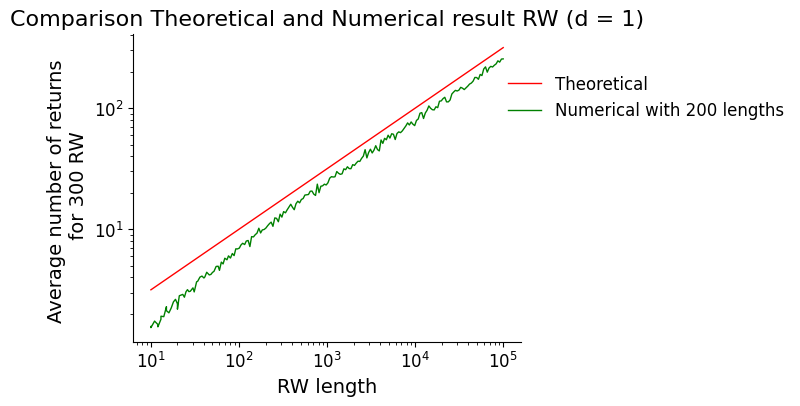

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# plot theoretical result
ax.loglog(
    length_array, length_array**(1/2),
    color="red",
    lw=1,
    label="Theoretical")

# plot numerical result
ax.loglog(
    length_array, num_returns_array, 
    color="green",
    lw=1,
    label=f"Numerical with {num} lengths"
)

# add axis labels
ax.set_xlabel("RW length")
ax.set_ylabel(f"Average number of returns \n for {num_trajs} RW")

# add a legend
ax.legend(loc=(0.95, 0.7), frameon=False)

# add a title (e.g. that says what dimension we used)
ax.set_title(f"Comparison Theoretical and Numerical result RW (d = {dim})")

### Exercise 3.6
Plot the average number of returns to the origin of a 2D RW as a function of the RW length. Do your results verify the $log(n)$ scaling? What are the best axis scales to use in this case?

In [11]:
%%time
# do the simulations for d=2
dim_2=2
num_trajs = 300
num_returns_array = np.array([
    get_average_num_returns(length, dim_2, num_trajs)
    for length in length_array
])

CPU times: user 12min 22s, sys: 315 ms, total: 12min 23s
Wall time: 12min 23s


Text(0.5, 1.0, 'Comparison Theoretical and Numerical result RW (d = 2)')

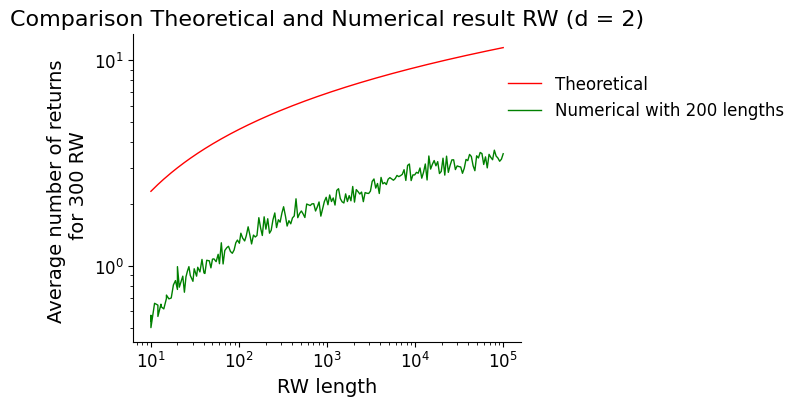

In [12]:
# plot the numerical results + theory
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# plot theoretical result
ax.loglog(
    length_array, np.log(length_array),
    color="red",
    lw=1,
    label="Theoretical")

# plot numerical result
ax.loglog(
    length_array, num_returns_array, 
    color="green",
    lw=1,
    label=f"Numerical with {num} lengths"
)

# add axis labels
ax.set_xlabel("RW length")
ax.set_ylabel(f"Average number of returns \n for {num_trajs} RW")

# add a legend
ax.legend(loc=(0.95, 0.7), frameon=False)

# add a title (e.g. that says what dimension we used)
ax.set_title(f"Comparison Theoretical and Numerical result RW (d = {dim_2})")

### Exercise 3.7
Show numerically that, for $d=3$ and $d=4$, the expected number of returns to the origin is **constant**.

In [13]:
%%time
# simulation for d=3
dim_3=3
num_trajs = 300
num_returns_array = np.array([
    get_average_num_returns(length, dim_3, num_trajs)
    for length in length_array
])

CPU times: user 12min 8s, sys: 305 ms, total: 12min 8s
Wall time: 12min 8s


Text(0.5, 1.0, 'Comparison Theoretical and Numerical result RW (d = 3)')

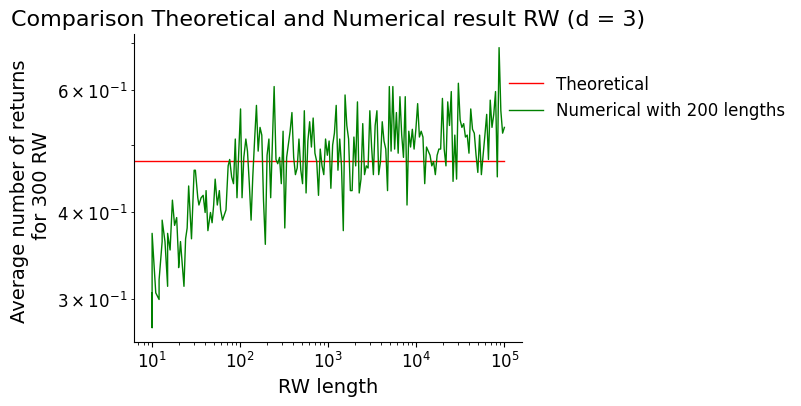

In [14]:
# plot the numerical results + theory
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# plot theoretical result
ax.loglog(
    [0,100000],[num_returns_array.sum()/num,num_returns_array.sum()/num],
    color="red",
    lw=1,
    label="Theoretical")
# plot numerical result
ax.loglog(
    length_array, num_returns_array, 
    color="green",
    lw=1,
    label=f"Numerical with {num} lengths"
)

# add axis labels
ax.set_xlabel("RW length")
ax.set_ylabel(f"Average number of returns \n for {num_trajs} RW")

# add a legend
ax.legend(loc=(0.95, 0.7), frameon=False)
# add a title (e.g. that says what dimension we used)
ax.set_title(f"Comparison Theoretical and Numerical result RW (d = {dim_3})")

In [15]:
%%time
#simulation for d=4
dim_4=4
num_trajs = 300
num_returns_array = np.array([
    get_average_num_returns(length, dim_4, num_trajs)
    for length in length_array
])

CPU times: user 12min 30s, sys: 853 ms, total: 12min 31s
Wall time: 12min 31s


Text(0.5, 1.0, 'Comparison Theoretical and Numerical result RW (d = 4)')

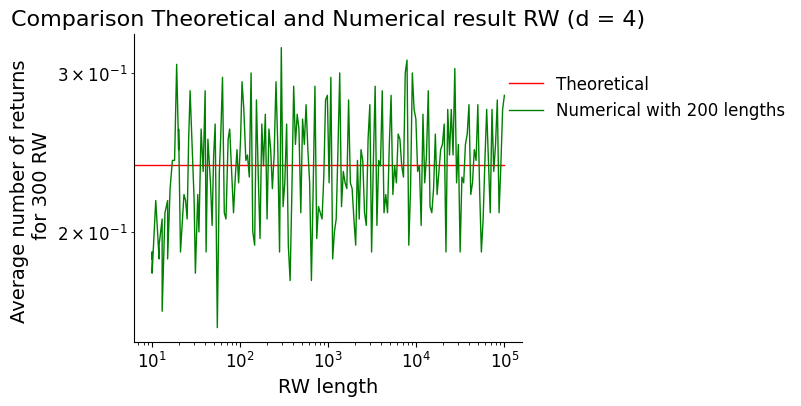

In [16]:
# plot the numerical results + theory
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# plot theoretical result

ax.loglog(
    [0,100000],[num_returns_array.sum()/num,num_returns_array.sum()/num],
    color="red",
    lw=1,
    label="Theoretical")
# plot numerical result
ax.loglog(
    length_array, num_returns_array, 
    color="green",
    lw=1,
    label=f"Numerical with {num} lengths"
)

# add axis labels
ax.set_xlabel("RW length")
ax.set_ylabel(f"Average number of returns \n for {num_trajs} RW")

# add a legend
ax.legend(loc=(0.95, 0.7), frameon=False)

# add a title (e.g. that says what dimension we used)
ax.set_title(f"Comparison Theoretical and Numerical result RW (d = {dim_4})")

# Self-Avoiding Walks
Self-avoiding walks (SAW) are simply random walks in a regular lattice with the additional constraint that no point can be visited more than once. That is, SAWs cannot intersect themselves. The most well-known application of SAW is to model linear polymers, where obviously two monomers cannot occupy the same space (excluded volume effect).


You can read more about self-avoiding walks in this nice introduction by Gordon Slade:

[Self-Avoiding Walks, by Gordon Slade](https://www.math.ubc.ca/~slade/intelligencer.pdf)

## Simulating Self-Avoiding Walks
Generating a SAW is not trivial. If you try to generate a SAW stochastically, that is, one step at a time, you will miserably fail: your walker might get into traps (configurations with no allowed movements), and if it does you will have to discard your simulation. It turns out you will have to discard your simulation *really* often, so that for large lengths, you will basically never find a valid path. In addition, the paths you will find for short lengths will not come up with the right probabilities. Bear in mind that we want to **uniformly sample** the set of SAW of given length $n$, SAW($n$). That is, we want that all paths from SAW($n$) are generated with the same probability.

The solution is to use a Monte Carlo algorithm that, given one element $\alpha \in \text{SAW}(n)$, generates a new one $\beta \in \text{SAW}(n)$ with some probability $P_{\alpha \beta}$. If in addition our algorithm satisfies **detailed balance** and is **ergodic**, then we known that it will converge to the equilibrium distribution (the uniform distribution in our case).


## The pivot algorithm
We will implement the pivot algorithm, which is simple, effective, and satisfies detailed balance and ergodicity. You can read about the details of the pivot algorithm here:

[The Pivot Algorithm: A Highly Efficient Monte Carlo Method for the Self-Avoiding Walk](https://link.springer.com/article/10.1007/BF01022990)

(tip: if you're at home, **do not** use tools such as sci-hub to download the paper).

Given a self-avoiding walk of length $n$, the pivot algorithm generates the next walk $\beta \in \text{SAW}(n)$ as follows:

1. **Choose a point of $\alpha$ at random**, splitting the path in two bits: the head (from the origin to the chosen point) and the tail (from the chosen point to the end of the path). Notice that both the head and the tail are SAWs.
2. **Apply a transformation to the tail**, leaving the head intact. The transformation must be an orthogonal transformation that leaves the regular lattice intact (so, either a reflection or a $90º, 180º$ or $270º$ rotation). For simplicity, we will use only **rotations** (read the paper to see why this is ok).
3. **Check if the new path is self-avoiding**. If so, return it. Otherwise, return the original path.

Iterating these steps one obtains a **Markov** chain of SAWs: $\alpha_1 \to \alpha_2 \to \dots \to \alpha_M $. Notice that $\alpha_i$ are not uncorrelated, but because the algorithm satisfies detailed balance and is ergodic, we know that it approaches the equilibrium distribution. This means that we can use our Markov chain to compute **expected values** as long as it is long enough.

## Implementing the pivot step in 2D
To implement the **pivot algorithm** in 2D, we will write one function that does steps 1 and 2, and another function that does step 3. We will also need a function to generate standard 2D random walks.

### Exercise 3.8
Write a function `get_traj` that generates a 2D random walk of given length.

In [17]:
def get_traj(length):
    """Generate a 2D random walk of given length"""
    
    traj = np.ndarray(shape=(length, 2), dtype = int)
    seq = [1,-1]
    
    traj[0,:] = 0 #per posizionarmi nell'orgine
    
    for i in range (1,length):
        n = random.randint(0,1)
        traj[i,:] = traj [i-1,:]
        traj[i,n] += random.choice(seq)

    return traj

### Exercise 3.9
Write a function `pivot_traj` that, given a 2D random walk, performs steps 1 and 2 of the pivot algorithm. Some useful functions:
```python
np.random.randint()
np.concatenate()
```
You might also want to multiply matrices using the `@` operator:
```python
>>> a = np.array([[1, 2], [3, 4], [5, 6]])
>>> b = np.array([1, 1])
>>> a @ b
array([ 3,  7, 11])
```


In [18]:
def pivot_traj(traj):
    """Apply a random rotation to part of a RW."""
    
    # choose the pivot
    pivot_index = np.random.randint(0,traj.shape[0])
    pivot_point = traj[pivot_index]
    
    # split head and tail
    traj_head, traj_tail = np.split(traj, [pivot_index])
    
    # define the rotation matrices
    symmetries = [
        # 90 deg rotation
        np.array([[ 0, -1], [1 , 0]]),
        # 180 deg rotation
        np.array([[-1 , 0], [0 , -1]]),
        # 270 deg rotation
        np.array([[0 , 1], [-1 , 0]]),
    ]
    
    # choose one rotation at random
    symmetry = symmetries[random.choice([0,1,2])]

    # apply the transformation to the tail
    new_tail = ((traj_tail - pivot_point) @ symmetry) + pivot_point
    
    # join the old head with the new tail
    new_traj = np.concatenate((traj_head, new_tail), axis = 0)
    
    return new_traj

### Exercise 3.10
Write a function that counts the number of self-intersections of a RW. Notice that SAWs have 0 self intersections, so that will solve step 3 of the pivot algorithm, but will also be useful to generate the initial condition. One way of approaching this exercise is to count how many *different* points the path visits.

In [19]:
def count_self_intersections(traj):
    """Count the number of self-intersections of a RW"""
    
    counter = 0
    
    for i in range(1, traj.shape[0]) :
        for j in range(i):
            if np.all(traj[j] == traj[i]) :
                counter += 1
                break
                
    return counter

### Exercise 3.11
Verify that your `count_self_intersecitons` function works properly by using short trajectories for which you know the answer.

In [20]:
%%time
# your verifications here
rw = get_traj(6)
print("Random Walk 2D")
print(rw)

self_int = count_self_intersections(rw)
print("count self intersections")
print(self_int)

Random Walk 2D
[[ 0  0]
 [-1  0]
 [-2  0]
 [-2 -1]
 [-2 -2]
 [-1 -2]]
count self intersections
0
CPU times: user 471 µs, sys: 0 ns, total: 471 µs
Wall time: 489 µs


## Generating the initial condition
You might have noticed that the pivot algorithm requires an element of SAW($n$) as starting condition, to then generate a Markov chain easily. But how do you get this first element? We will use the following strategy:
1. Generate a standard 2D random walk, and count the number of self intersections.
2. Apply the pivot transformation to get a new 2D random walk, and count the number of self-intersections-
3. If the number of self-intersections has decreased or not changed, keep the new path. Else, keep the old one.
4. Go to 2, till the number of self-intersections is 0.

### Exercise 3.12
Write a function `get_first_SAW` that generates a SAW of given length

In [21]:
def get_first_SAW(length, max_tries=1000000):
    
    traj = get_traj(length) # standard RW 2D
    
    while (count_self_intersections(traj) != 0):
            traj = pivot_traj(traj)
            
    return traj

### Exercise 3.13
Generate and plot some 2D SAWs of different lengths. Be carefull, raise the length slowly! You can measure how long a cell takes executing using the `%%time` magic at the top of a cell.

In [22]:
%%time

length_1 = 5
RW_1 = get_first_SAW(length_1)

CPU times: user 0 ns, sys: 1.98 ms, total: 1.98 ms
Wall time: 1.54 ms


In [23]:
%%time

length_2 = 10
RW_2 = get_first_SAW(length_2)

CPU times: user 4.04 ms, sys: 0 ns, total: 4.04 ms
Wall time: 4.04 ms


In [24]:
%%time

length_3 = 25
RW_3 = get_first_SAW(length_3)

CPU times: user 16.7 s, sys: 243 ms, total: 17 s
Wall time: 17 s


In [25]:
%%time

length_4 = 30
RW_4 = get_first_SAW(length_4)

CPU times: user 4min 59s, sys: 1 s, total: 5min
Wall time: 5min


Text(0.5, 1.0, 'SAW with 30 length')

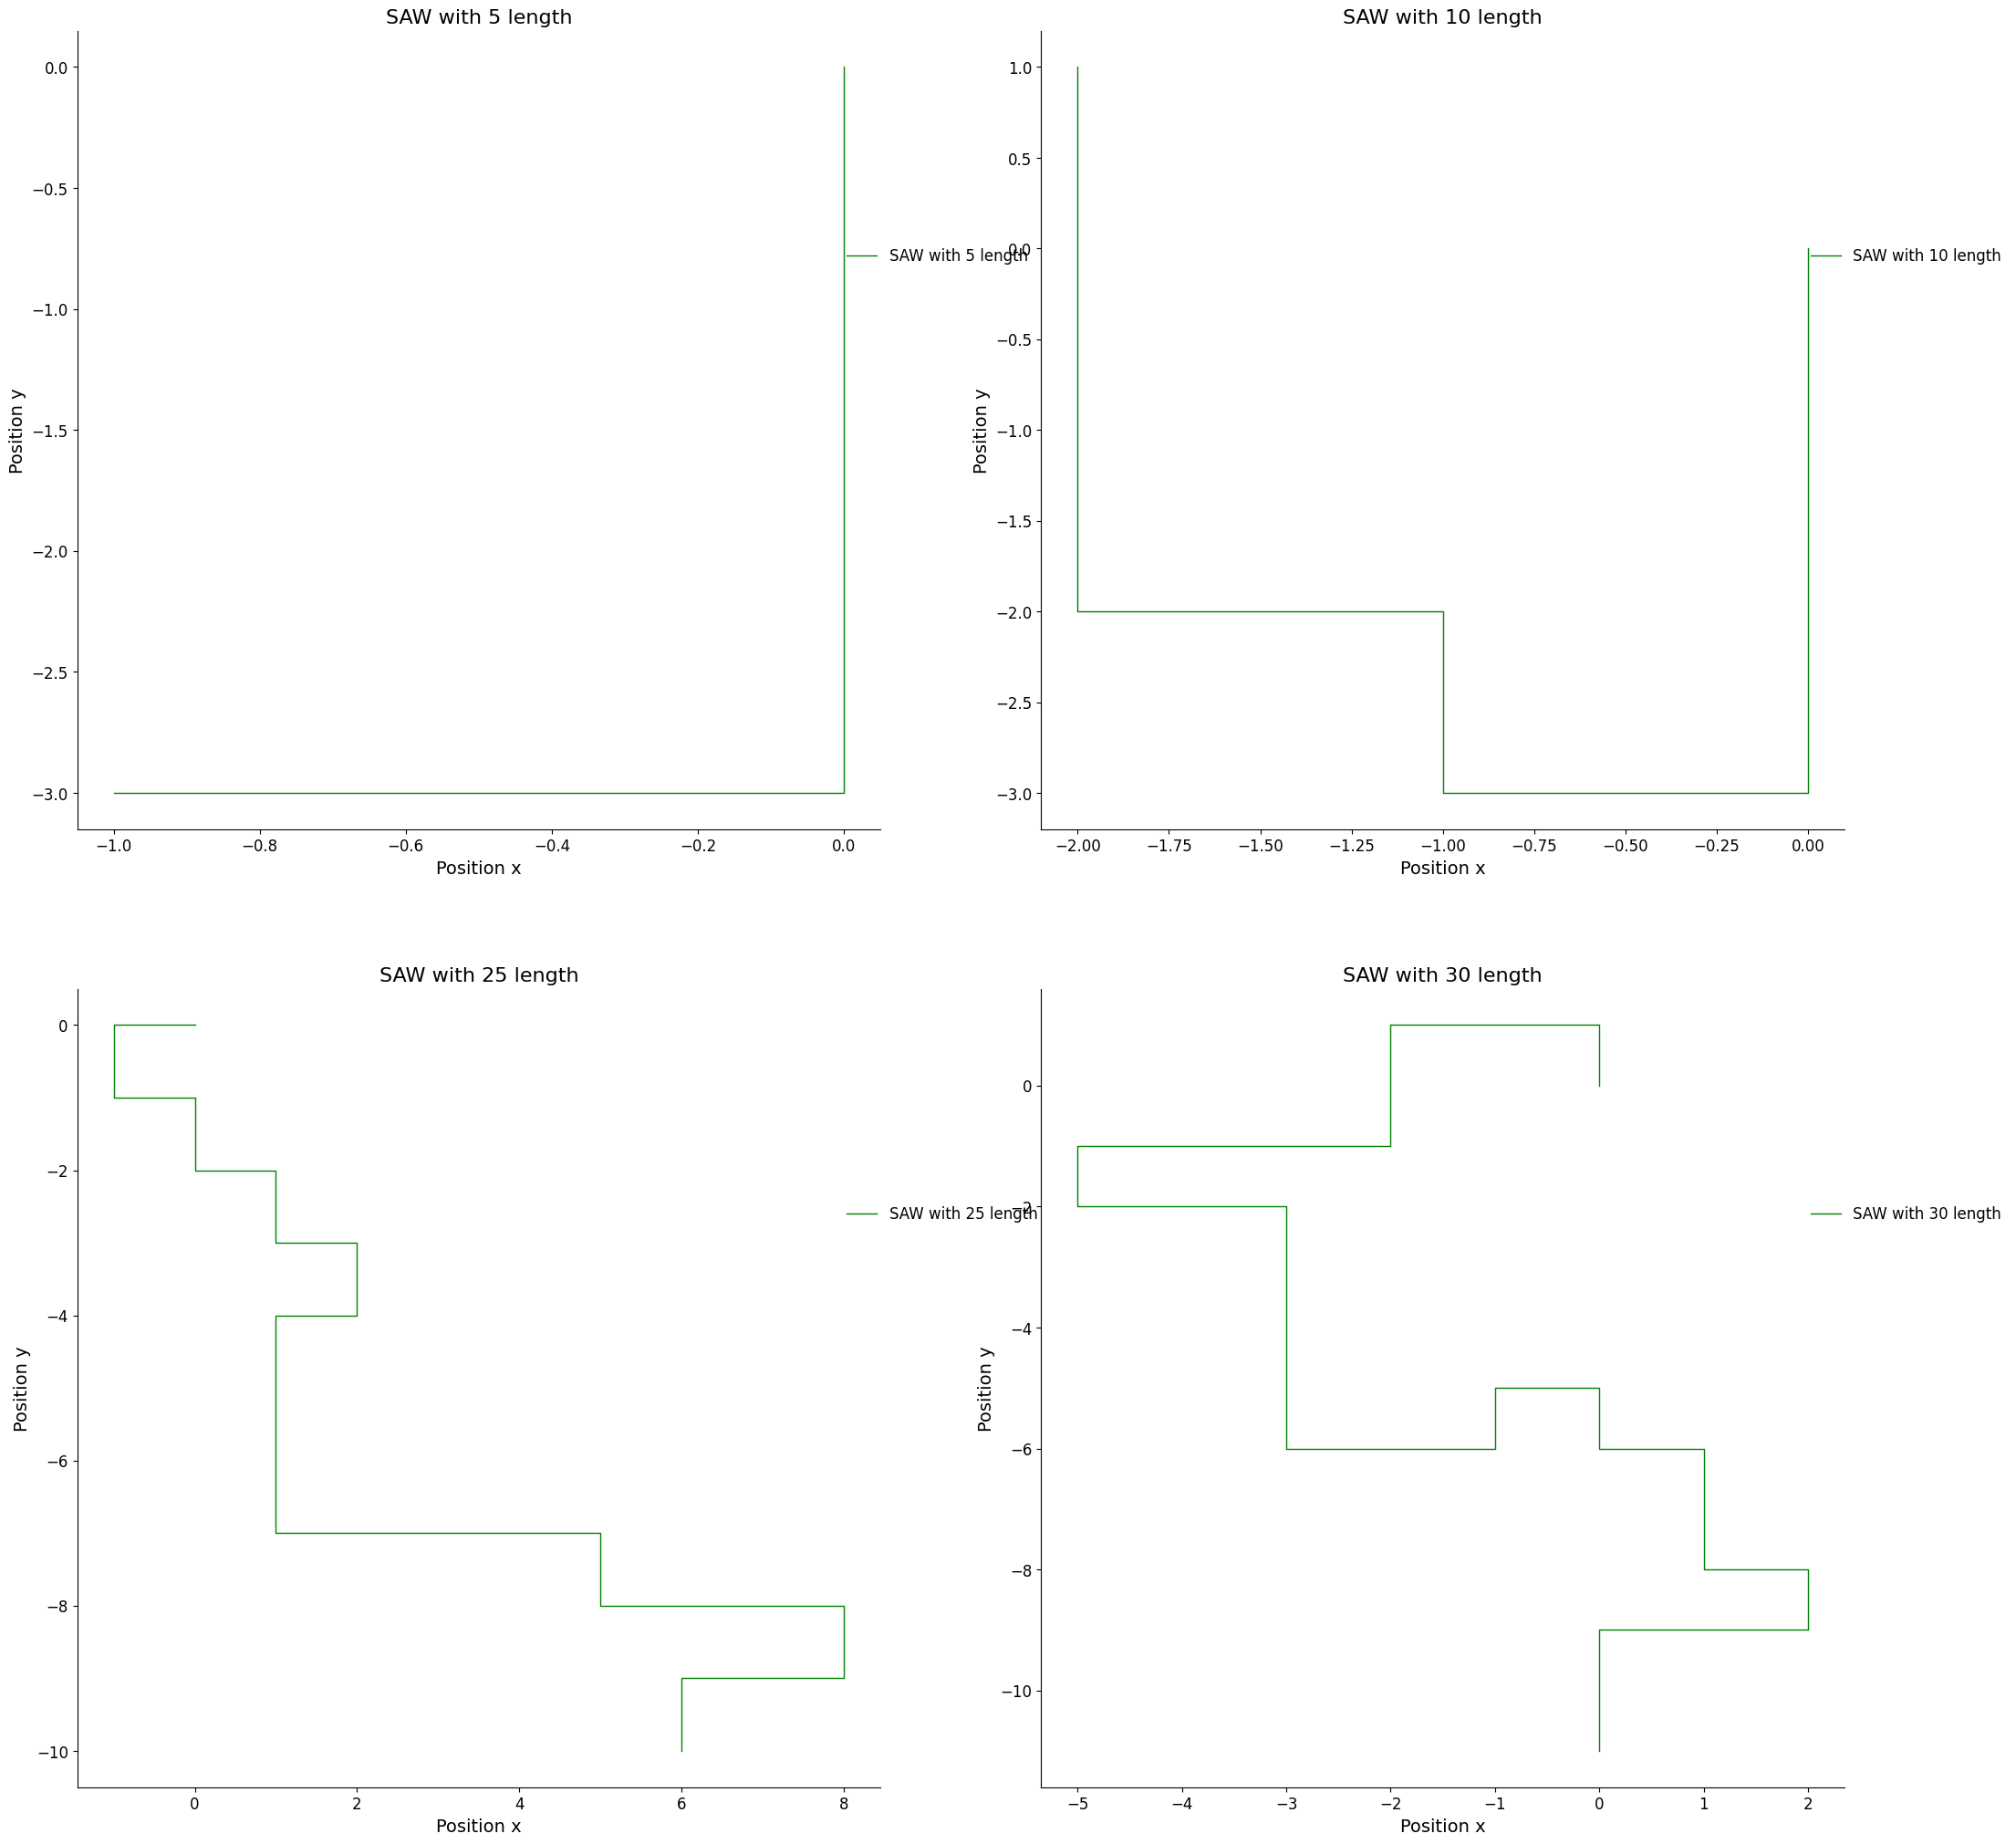

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))

# plot length_1
ax1.plot(
    RW_1[:,0], RW_1[:,1],
    color="green",
    lw=1,
    label=f"SAW with {length_1} length"
)

# plot length_2
ax2.plot(
    RW_2[:,0], RW_2[:,1],
    color="green",
    lw=1,
    label=f"SAW with {length_2} length"
)

# plot length_3
ax3.plot(
    RW_3[:,0], RW_3[:,1],
    color="green",
    lw=1,
    label=f"SAW with {length_3} length"
)

# plot length_4
ax4.plot(
    RW_4[:,0], RW_4[:,1],
    color="green",
    lw=1,
    label=f"SAW with {length_4} length"
)

# add labels for axes
ax1.set_xlabel("Position x")
ax1.set_ylabel("Position y")
ax2.set_xlabel("Position x")
ax2.set_ylabel("Position y")
ax3.set_xlabel("Position x")
ax3.set_ylabel("Position y")
ax4.set_xlabel("Position x")
ax4.set_ylabel("Position y")

# add legend
ax1.legend(loc=(0.95, 0.7), frameon=False)
ax2.legend(loc=(0.95, 0.7), frameon=False)
ax3.legend(loc=(0.95, 0.7), frameon=False)
ax4.legend(loc=(0.95, 0.7), frameon=False)

# add title
ax1.set_title(f"SAW with {length_1} length")
ax2.set_title(f"SAW with {length_2} length")
ax3.set_title(f"SAW with {length_3} length")
ax4.set_title(f"SAW with {length_4} length")

### Exercise 3.14
Write a function `get_next_SAW` that, given a SAW, generates another SAW using the pivot algorithm. Your function should check that the input RW is really a SAW. Remember the steps:

1. Apply the pivot transformation
2. Check if the new path is self-avoiding. **If so, return it. Otherwise, return the original path.**

In [27]:
def get_next_SAW(traj):
    # make sure input traj is SAW
    assert count_self_intersections(traj) == 0
    
    # pivot step
    proposed_traj = pivot_traj(traj)
    
    # count intersections
    num_intersections = count_self_intersections(proposed_traj)
    
    # if it's a SAW
    if num_intersections == 0:
        return proposed_traj
    
    # if not
    else:
        return traj

### Mean Squared Displacement in SAW
A quantity of interest in RWs is the mean squared displacement, which is simply the (squared) distance between the endpoints of the walk. Usually, one writes

$$
\left\langle X(n)^2 \right\rangle \sim n^{2 \nu}
$$

As you know, for a standard RW of $n$ steps, the mean-squared displacement scales like $n$, so $\nu=1/2$. However, the exponent for SAW is **different**! Althought it has not been formally proven (still), it is believed that the exponent for SAW is $\nu=3/4$. That is, for a self-avoiding random walk, the mean squared displacement scales as $n^{3/2}$.

### Exercise 3.15
Explain why it makes sense that the mean-squared displacement exponent of SAW is **greater** than that of standard RW. 

L'esponente dello spostamento quadratico medio ha un valore maggiore per SAW perchè non potendo ritornare nelle stesse posizioni è più probabile che mi allontani maggiormente dal punto di partenza

### Exercise 3.16
Verify numerically the scaling of the mean-squared displacement of SAW. Notice that you don't need to store all the SAWs, just the endpoints. You could follow this scheme:

1. Generate a first SAW with your `get_first_SAW()` function
2. Generate the next SAW using your `get_next_SAW()` function, and store the endpoint.
3. Iterate step 2 for as many steps as required
4. Compute the average mean-squared displacement of the stored endpoints

Then repeating steps 1-4 for different lengths, and plot the results in double-logarithmic axis. Compare your results with the theoretical exponent. Do they agree?

In [28]:
def mean_squared_displacement(length, steps):
    
    saw = get_first_SAW(length)
    norma_quadra = np.ndarray(shape = (steps), dtype = int)
    
    for i in range(steps):   
        saw = get_next_SAW(saw)
        norma_quadra[i] = np.linalg.norm(saw[-1])**2
        
    return np.mean(norma_quadra)

In [29]:
%%time

length_min = 2
length_max = 30
num = 28
# generate points logarithmically spaces
# and convert them to integers
length_array = np.array([
    int(x)
    for x in np.geomspace(length_min, length_max, num)
])

steps = 50

msd = np.array([
    mean_squared_displacement(length, steps)
    for length in length_array
])

CPU times: user 3min 55s, sys: 1.49 s, total: 3min 56s
Wall time: 3min 56s


Text(0.5, 1.0, 'Comparison Theoretical and Numerical result MSD for 28 different lengths \n number steps = 50')

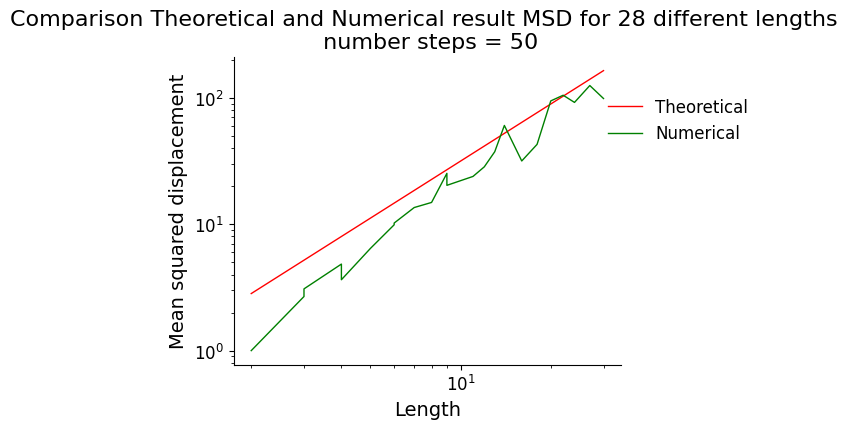

In [30]:
# plot the numerical results + theory
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# plot theoretical result
ax.loglog(
    length_array, length_array**(3/2),
    color="red",
    lw=1,
    label="Theoretical")

# plot numerical result
ax.loglog(
    length_array, msd, 
    color="green",
    lw=1,
    label=f"Numerical"
)

# add axis labels
ax.set_xlabel("Length")
ax.set_ylabel("Mean squared displacement")

# add a legend
ax.legend(loc=(0.95, 0.7), frameon=False)

# add a title (e.g. that says what dimension we used)
ax.set_title(f"Comparison Theoretical and Numerical result MSD for {length_array.shape[0]} different lengths \n number steps = {steps}")